In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import warnings
warnings.filterwarnings('ignore')
from matplotlib.ticker import ScalarFormatter
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, recall_score
from optbinning import OptimalBinning

In [36]:
df = pd.read_csv('data/mortgage_sample.csv')

In [37]:
df = df[df['sample'] == 'public']

In [38]:
df

,Unnamed: 0,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,...,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time,sample,TARGET
0,0,1,25,-7,25,113,41303.4200,24.4983,9.2000,226.2900,...,45000.0000,715,69.4000,9.2000,87.0300,0.0000,0.0000,0.0000,public,0.0000
1,1,1,26,-7,25,113,41061.9500,24.4839,9.2000,225.1000,...,45000.0000,715,69.4000,9.2000,87.0300,0.0000,0.0000,0.0000,public,0.0000
2,2,1,27,-7,25,113,40804.4200,24.6268,9.2000,222.3900,...,45000.0000,715,69.4000,9.2000,87.0300,0.0000,0.0000,0.0000,public,0.0000
3,3,1,28,-7,25,113,40483.8900,24.7359,9.2000,219.6700,...,45000.0000,715,69.4000,9.2000,87.0300,0.0000,0.0000,0.0000,public,0.0000
4,4,1,29,-7,25,113,40367.0600,24.9255,9.2000,217.3700,...,45000.0000,715,69.4000,9.2000,87.0300,0.0000,0.0000,0.0000,public,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622475,622475,49999,56,17,52,177,265013.6000,45.5863,2.7740,181.4300,...,345000.0000,779,60.0000,1.7500,179.4500,0.0000,0.0000,0.0000,public,0.0000
622476,622476,49999,57,17,52,177,263608.6400,43.9470,2.7620,187.2000,...,345000.0000,779,60.0000,1.7500,179.4500,0.0000,0.0000,0.0000,public,0.0000
622477,622477,49999,58,17,52,177,262187.3500,43.4386,2.7540,188.3700,...,345000.0000,779,60.0000,1.7500,179.4500,0.0000,0.0000,0.0000,public,0.0000
622478,622478,49999,59,17,52,177,260775.0500,43.3704,2.7480,187.6500,...,345000.0000,779,60.0000,1.7500,179.4500,0.0000,0.0000,0.0000,public,0.0000


In [39]:
df.drop(df[df['balance_orig_time'] == 0].index, inplace=True)
df.drop(df[df['balance_time'] == 0].index, inplace=True)

In [40]:
def get_outliers_iqr(df, column_name):
    sns.set_palette("turbo")
    fig, ax = plt.subplots(figsize=(10, 6))
    boxplot = ax.boxplot(df[column_name], vert=False, patch_artist=True)

    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    lower_bound_ex = q1 - 3 * iqr
    upper_bound_ex = q3 + 3 * iqr

    outliers = df[((df[column_name] < lower_bound) & (df[column_name] >= lower_bound_ex)) | (
            (df[column_name] > upper_bound) & (df[column_name] <= upper_bound_ex))]
    ext_outliers = df[(df[column_name] < lower_bound_ex) | (df[column_name] > upper_bound_ex)]

    ax.scatter(outliers[column_name], [1] * len(outliers),  alpha=0.7, label="Outliers", s=15, marker="o")
    ax.scatter(ext_outliers[column_name], [1] * len(ext_outliers), alpha=0.7, label="Extreme Outliers", s=20, marker="x")

    ax.axvline(lower_bound_ex, color="orange", linestyle="--", label="Lower Bound (3*IQR)")
    ax.axvline(upper_bound_ex, color="orange", linestyle="--", label="Upper Bound (3*IQR)")

    ax.set_yticklabels([column_name])
    ax.set_xlabel("Values")
    ax.set_title(f"Boxplot for {column_name} with Outliers")

    ax.legend()

    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))

    plt.show()
    return outliers, ext_outliers

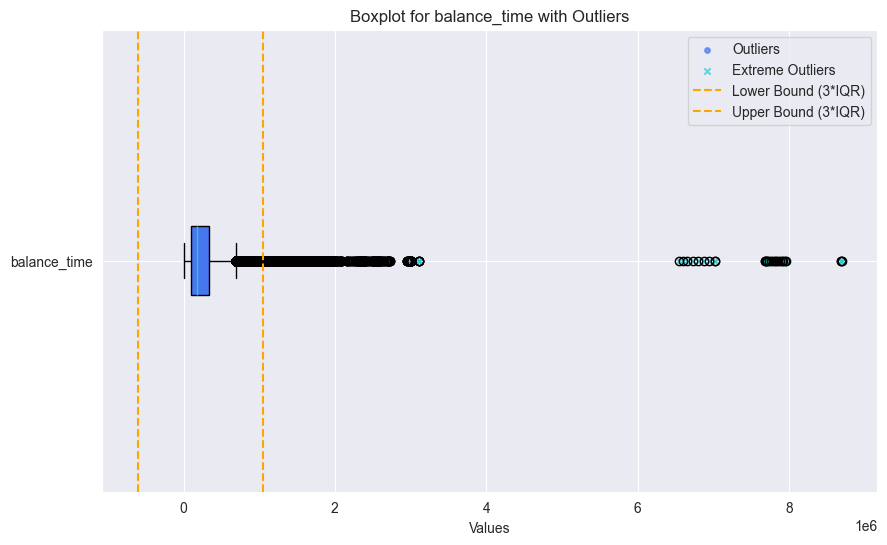

In [41]:
outl_bal, ext_outl_bal = get_outliers_iqr(df, 'balance_time')

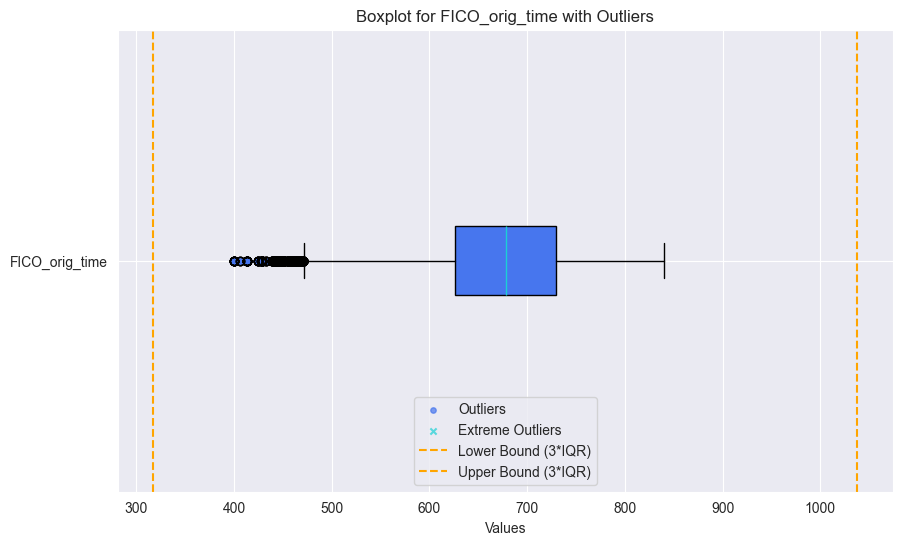

In [42]:
outl, ext_outl = get_outliers_iqr(df, 'FICO_orig_time')

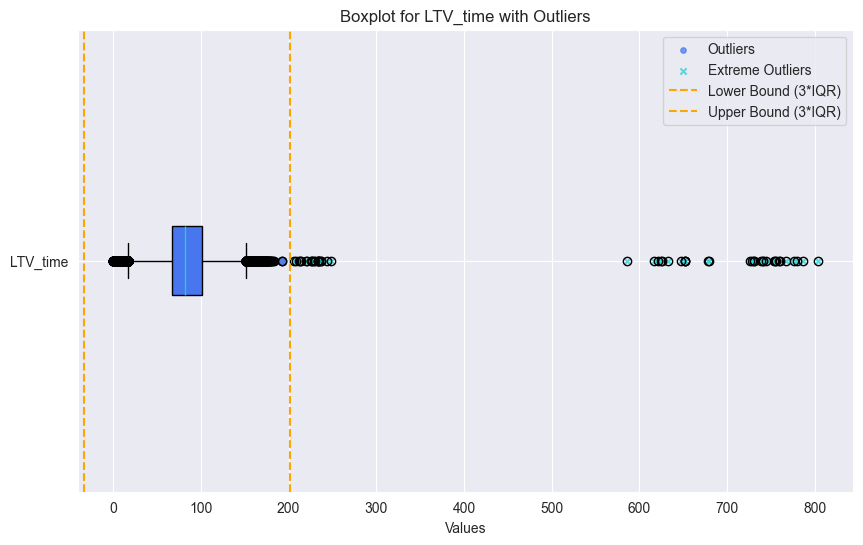

In [43]:
outl, ext_outl = get_outliers_iqr(df, 'LTV_time')
outliers = pd.concat([outl, ext_outl])
df = df.drop(outliers.index)

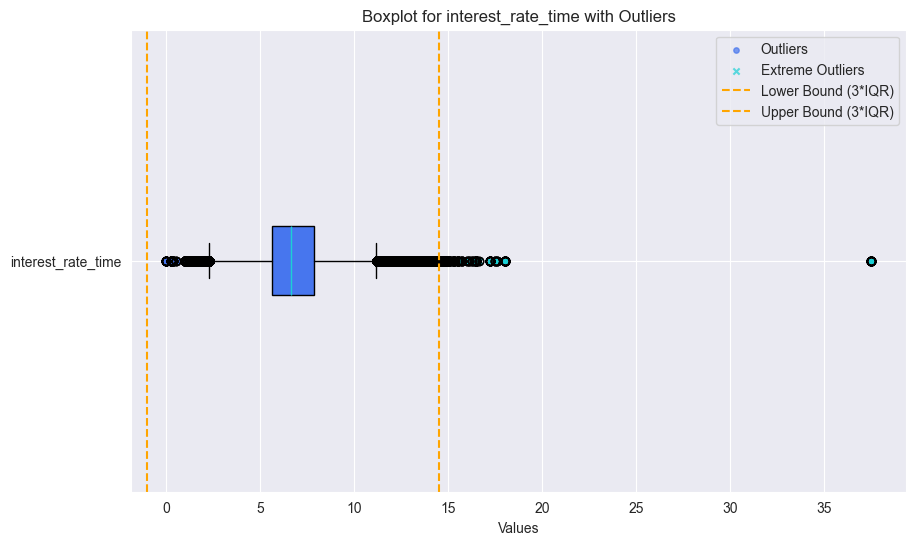

In [44]:
outl, ext_outl = get_outliers_iqr(df, 'interest_rate_time')
outliers = pd.concat([outl, ext_outl])
df = df.drop(outliers.index)

In [45]:
df['time_to_maturity'] = (df['mat_time'] - df['time'])
df['loan_age'] = (df['time'] - df['orig_time'])
df['hpi_relative_change'] = (df['hpi_time'] - df['hpi_orig_time']) / df['hpi_orig_time']
df['amount_paid'] = (df['balance_orig_time'] - df['balance_time']) / df['balance_orig_time']
df.drop(columns=['Unnamed: 0','sample', 'default_time', 'status_time', 'mat_time', 'orig_time', 'first_time', 'time', 'balance_time'], inplace=True)

### Exploratory Data Analysis

In [46]:
print(f"Sample borrowers: {len(df['id'].unique())}")
print(f"Number of defaults: {len(df[df['TARGET']==1]['id'].unique())}")
print(f"Default ratio: {round(len(df[df['TARGET']==1]['id'].unique())/len(df['id'].unique())*100,2)}%")

Sample borrowers: 43758
Number of defaults: 13257
Default ratio: 30.3%


In [47]:
# Check for missing values
# Missing values present only in LTV_time column
df.isnull().sum()

id                         0
LTV_time                   0
interest_rate_time         0
hpi_time                   0
gdp_time                   0
uer_time                   0
REtype_CO_orig_time        0
REtype_PU_orig_time        0
REtype_SF_orig_time        0
investor_orig_time         0
balance_orig_time          0
FICO_orig_time             0
LTV_orig_time              0
Interest_Rate_orig_time    0
hpi_orig_time              0
payoff_time                0
TARGET                     0
time_to_maturity           0
loan_age                   0
hpi_relative_change        0
amount_paid                0
dtype: int64

In [48]:
missing_ltv_ids = df[df['LTV_time'].isnull()]['id'].unique()

print("Borrower IDs with missing LTV_time:", missing_ltv_ids)

Borrower IDs with missing LTV_time: []


In [49]:
median_ltv = df['LTV_time'].median()
df['LTV_time'].fillna(median_ltv, inplace=True)

In [50]:
# Drop all completely duplicate rows
df.drop_duplicates(keep=False, inplace=True)
df[df.duplicated()]

,id,LTV_time,interest_rate_time,hpi_time,gdp_time,uer_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time,...,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,payoff_time,TARGET,time_to_maturity,loan_age,hpi_relative_change,amount_paid


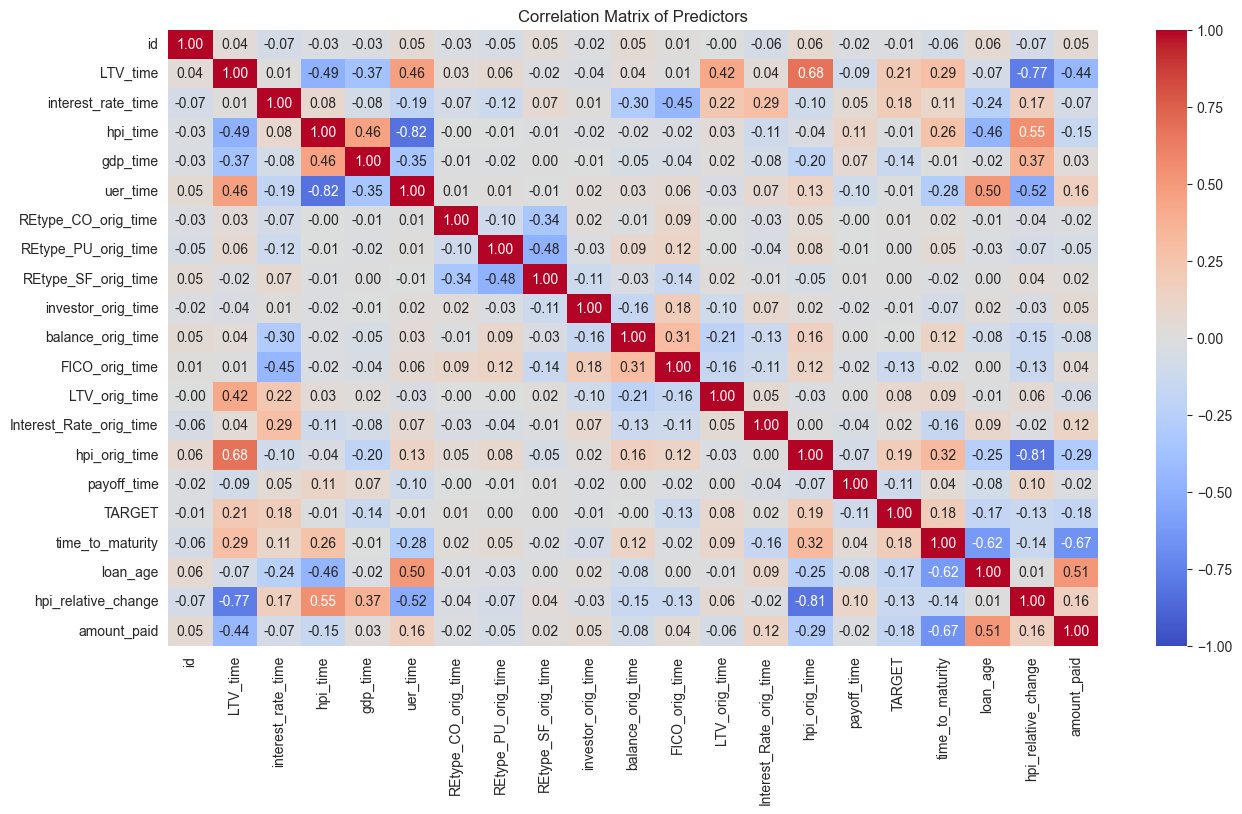

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Predictors')
plt.show()


In [52]:
df.drop(columns=['balance_orig_time', 'payoff_time'], inplace = True)

In [53]:
df.drop(columns=['hpi_orig_time'], inplace = True)

In [54]:
df

,id,LTV_time,interest_rate_time,hpi_time,gdp_time,uer_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,TARGET,time_to_maturity,loan_age,hpi_relative_change,amount_paid
0,1,24.4983,9.2000,226.2900,2.8991,4.7000,0,0,1,0,715,69.4000,9.2000,0.0000,88,32,1.6001,0.0821
1,1,24.4839,9.2000,225.1000,2.1514,4.7000,0,0,1,0,715,69.4000,9.2000,0.0000,87,33,1.5865,0.0875
2,1,24.6268,9.2000,222.3900,2.3617,4.4000,0,0,1,0,715,69.4000,9.2000,0.0000,86,34,1.5553,0.0932
3,1,24.7359,9.2000,219.6700,1.2292,4.6000,0,0,1,0,715,69.4000,9.2000,0.0000,85,35,1.5241,0.1004
4,1,24.9255,9.2000,217.3700,1.6930,4.5000,0,0,1,0,715,69.4000,9.2000,0.0000,84,36,1.4976,0.1030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622475,49999,45.5863,2.7740,181.4300,1.7171,6.6000,1,0,0,0,779,60.0000,1.7500,0.0000,121,39,0.0110,0.2318
622476,49999,43.9470,2.7620,187.2000,2.5561,6.2000,1,0,0,0,779,60.0000,1.7500,0.0000,120,40,0.0432,0.2359
622477,49999,43.4386,2.7540,188.3700,2.8686,6.2000,1,0,0,0,779,60.0000,1.7500,0.0000,119,41,0.0497,0.2400
622478,49999,43.3704,2.7480,187.6500,2.4436,5.7000,1,0,0,0,779,60.0000,1.7500,0.0000,118,42,0.0457,0.2441


In [55]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

X = add_constant(numeric_df)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                    feature      VIF
0                     const 683.5867
1                        id   1.0277
2                  LTV_time  14.9320
3        interest_rate_time   1.7144
4                  hpi_time   4.1012
5                  gdp_time   1.4357
6                  uer_time   3.8238
7       REtype_CO_orig_time   1.2874
8       REtype_PU_orig_time   1.5141
9       REtype_SF_orig_time   1.6781
10       investor_orig_time   1.0865
11           FICO_orig_time   1.3850
12            LTV_orig_time   3.9321
13  Interest_Rate_orig_time   1.1742
14                   TARGET   1.1195
15         time_to_maturity   2.3620
16                 loan_age   2.5189
17      hpi_relative_change   7.5711
18              amount_paid   3.9453


### Modelling

In [56]:
df = df.groupby('id').apply(lambda x: x.sample(n=1, random_state=42)).reset_index(drop=True)

In [57]:
predictors = ['LTV_time', 'interest_rate_time', 'gdp_time',
              'hpi_time', 'FICO_orig_time', 'investor_orig_time', 'REtype_CO_orig_time',
              'REtype_PU_orig_time', 'REtype_SF_orig_time', 'hpi_relative_change', 'amount_paid', 'loan_age', 'time_to_maturity', 'uer_time']

df_clean = df.dropna(subset=['TARGET'])

df_clean = df_clean.dropna(subset=predictors)


X = df_clean[predictors]  
y = df_clean['TARGET']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

binned_features_train = []
binned_features_test = []
bin_mappings = {}  # Dictionary to store bin mappings for each predictor

for predictor in predictors:
    optbin = OptimalBinning(name=predictor, dtype="numerical", solver="cp", max_n_bins=10)
    optbin.fit(X_train[predictor].values, y_train)
    optbin.binning_table.build()

    bin_edges = optbin.binning_table.splits
    bin_edges = [-np.inf] + list(bin_edges) + [np.inf]  

    bin_mapping = {i: i for i in range(len(bin_edges) - 1)}
    bin_mappings[predictor] = bin_mapping  

    train_binned = np.digitize(X_train[predictor].values, bins=bin_edges, right=False) - 1
    test_binned = np.digitize(X_test[predictor].values, bins=bin_edges, right=False) - 1

    binned_features_train.append(train_binned)
    binned_features_test.append(test_binned)

    print(f"Predictor: {predictor}")
    print(f"Bin Edges: {bin_edges}")
    print(f"Ordinal Bin Mapping: {bin_mapping}")

X_train_binned = pd.DataFrame(np.column_stack(binned_features_train), columns=predictors)
X_test_binned = pd.DataFrame(np.column_stack(binned_features_test), columns=predictors)
    
X_train_binned = pd.DataFrame(np.column_stack(binned_features_train), columns=predictors)
X_test_binned = pd.DataFrame(np.column_stack(binned_features_test), columns=predictors)

logreg = LogisticRegression(class_weight='balanced', random_state=42, penalty='l2')
logreg.fit(X_train_binned, y_train)

y_pred_proba = logreg.predict_proba(X_test_binned)[:, 1]  
y_pred = (y_pred_proba >= 0.5).astype(int)

y_pred_proba_train = logreg.predict_proba(X_train_binned)[:, 1] 
y_pred_train = (y_pred_proba_train >= 0.5).astype(int)

train_accuracy = accuracy_score(y_train, y_pred_train)
train_roc_auc = roc_auc_score(y_train, y_pred_train)
train_conf_matrix = confusion_matrix(y_train, y_pred_train)
train_class_report = classification_report(y_train, y_pred_train)


test_accuracy = accuracy_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
test_conf_matrix = confusion_matrix(y_test, y_pred)
test_class_report = classification_report(y_test, y_pred)

Predictor: LTV_time
Bin Edges: [-inf, 63.39035606384277, 69.68163299560547, 72.40613174438477, 75.47793197631836, 78.25965881347656, 80.12125015258789, 95.14337921142578, 102.40520477294922, 111.39334487915039, inf]
Ordinal Bin Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
Predictor: interest_rate_time
Bin Edges: [-inf, 3.887500047683716, 5.7769999504089355, 6.315500020980835, 6.516499996185303, 6.868499994277954, 7.2174999713897705, 7.491999864578247, 7.994499921798706, 9.015000343322754, inf]
Ordinal Bin Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
Predictor: gdp_time
Bin Edges: [-inf, -0.018115989863872528, 1.1400359272956848, 1.8631020784378052, 2.3943424224853516, 2.6192742586135864, 2.8838653564453125, inf]
Ordinal Bin Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Predictor: hpi_time
Bin Edges: [-inf, 158.8550033569336, 186.51499938964844, 190.62000274658203, 199.94000244140625, inf]
Ordinal Bin Mapping: {0: 0, 1: 1, 2: 2, 3:

In [58]:
print("TRAIN RESULTS")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"AUC-ROC: {train_roc_auc:.4f}")
print(f"Recall {recall_score(y_train, y_pred_train):.4f}")
print(f"Gini Index: {2 * train_roc_auc - 1:.4f}")
print("Classification Report:")
print(train_class_report)

TRAIN RESULTS
Accuracy: 0.7475
AUC-ROC: 0.7535
Recall 0.7655
Gini Index: 0.5071
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.74      0.82     26327
         1.0       0.49      0.77      0.60      8679

    accuracy                           0.75     35006
   macro avg       0.70      0.75      0.71     35006
weighted avg       0.80      0.75      0.76     35006


TEST RESULTS
Accuracy: 0.7375
AUC-ROC: 0.8118
Recall 0.7628
Gini Index: 0.6237
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.73      0.81      6568
         1.0       0.48      0.76      0.59      2184

    accuracy                           0.74      8752
   macro avg       0.69      0.75      0.70      8752
weighted avg       0.80      0.74      0.75      8752


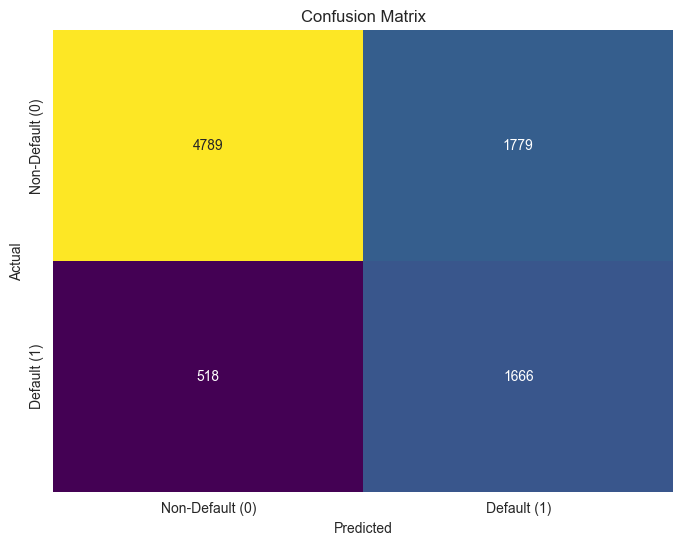

In [59]:
print("TEST RESULTS")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"AUC-ROC: {test_roc_auc:.4f}")
print(f"Recall {recall_score(y_test, y_pred):.4f}")
print(f"Gini Index: {2 * test_roc_auc - 1:.4f}")
print("Classification Report:")
print(test_class_report)


conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False,
            xticklabels=['Non-Default (0)', 'Default (1)'], yticklabels=['Non-Default (0)', 'Default (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [60]:
def predict_default_probability(model, instance_data,):
    y_pred_proba = model.predict_proba([instance_data])[:, 1]
    print(f"The predicted probability of default is: {y_pred_proba[0]:.4f}")


In [61]:
predict_default_probability(logreg, X_test_binned.iloc[9])
X_test_binned.iloc[9]

The predicted probability of default is: 0.6026


LTV_time               5
interest_rate_time     5
gdp_time               3
hpi_time               4
FICO_orig_time         1
investor_orig_time     0
REtype_CO_orig_time    0
REtype_PU_orig_time    0
REtype_SF_orig_time    1
hpi_relative_change    4
amount_paid            4
loan_age               3
time_to_maturity       3
uer_time               0
Name: 9, dtype: int64

In [62]:
predict_default_probability(logreg, X_test_binned.iloc[199])
X_test_binned.iloc[199]

The predicted probability of default is: 0.0447


LTV_time               3
interest_rate_time     2
gdp_time               6
hpi_time               1
FICO_orig_time         8
investor_orig_time     0
REtype_CO_orig_time    0
REtype_PU_orig_time    0
REtype_SF_orig_time    1
hpi_relative_change    5
amount_paid            4
loan_age               1
time_to_maturity       3
uer_time               5
Name: 199, dtype: int64

In [63]:
A = 50  # Offset
B = 500  # Scaling factor

pd_bins = logreg.predict_proba(X_train_binned)[:, 1] 

scores = A - B * np.log(pd_bins / (1 - pd_bins))

max_pd_bin = pd_bins.argmax()  
max_pd_score = scores[max_pd_bin]  

centered_scores = scores - max_pd_score

scorecard_data = []

for i, predictor in enumerate(predictors):
    num_bins = X_train_binned[predictor].nunique()  
    for bin_idx in range(num_bins):
        scorecard_data.append({
            'Feature': predictor,
            'Bin': bin_idx,
            'PD': pd_bins[bin_idx],
            'Score': centered_scores[bin_idx]
        })

scorecard_df = pd.DataFrame(scorecard_data)

pd.set_option('display.float_format', lambda x: '%.4f' % x)
score_min = scorecard_df["Score"].min()
score_max = scorecard_df["Score"].max()

scorecard_df["Normalized_Score"] = (scorecard_df["Score"] - score_min) / (score_max - score_min) * 1000


In [64]:
scorecard_df

,Feature,Bin,PD,Score,Normalized_Score
0,LTV_time,0,0.4301,1682.7320,413.6550
1,LTV_time,1,0.0637,2885.8320,1000.0000
2,LTV_time,2,0.5066,1528.8135,338.6411
3,LTV_time,3,0.7024,1112.7264,135.8561
4,LTV_time,4,0.2753,2025.9264,580.9149
...,...,...,...,...,...
84,uer_time,4,0.2753,2025.9264,580.9149
85,uer_time,5,0.5284,1485.2958,317.4322
86,uer_time,6,0.8034,838.2724,2.0977
87,uer_time,7,0.8048,833.9682,0.0000
